# Frequency correlation plots for simulated populations test data with nested clades from a full tree

Example code for how to calculate frequency correlation plots from augur forecasting builds.

In [1]:
import altair as alt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_style("white")
plt.style.use("huddlej")

In [3]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [4]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [5]:
def matthews_correlation_coefficient(tp, tn, fp, fn):
    """Return Matthews correlation coefficient for values from a confusion matrix.
    Implementation is based on the definition from wikipedia:

    https://en.wikipedia.org/wiki/Matthews_correlation_coefficient
    """
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    if denominator == 0:
            denominator = 1

    return float(numerator) / denominator

def get_matthews_correlation_coefficient_for_data_frame(freq_df, return_confusion_matrix=False):
        """Calculate Matthew's correlation coefficient from a given pandas data frame
        with columns for initial, observed, and predicted frequencies.
        """
        observed_growth = (freq_df["frequency_final"] > freq_df["frequency"])
        predicted_growth = (freq_df["projected_frequency"] > freq_df["frequency"])
        true_positives = ((observed_growth) & (predicted_growth)).sum()
        false_positives= ((~observed_growth) & (predicted_growth)).sum()

        observed_decline = (freq_df["frequency_final"] < freq_df["frequency"])
        predicted_decline = (freq_df["projected_frequency"] < freq_df["frequency"])
        true_negatives = ((observed_decline) & (predicted_decline)).sum()
        false_negatives = ((~observed_decline) & (predicted_decline)).sum()

        mcc = matthews_correlation_coefficient(
            true_positives,
            true_negatives,
            false_positives,
            false_negatives
        )

        if return_confusion_matrix:
            confusion_matrix = {
                "tp": true_positives,
                "tn": true_negatives,
                "fp": false_positives,
                "fn": false_negatives
            }
            
            return mcc, confusion_matrix
        else:
            return mcc

## Load data

In [6]:
min_clade_frequency = 0.15

In [7]:
precision = 4

In [8]:
data_root = "../results/builds/simulated/simulated_sample_3_test_tree"

In [9]:
data_root_full_tree = "../results/builds/simulated/simulated_sample_3_full_test_tree"

In [10]:
first_validation_timepoint = "2040-04-01"

In [11]:
tips = pd.read_csv(
    "%s/tip_attributes_with_weighted_distances.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["strain", "timepoint", "frequency"]
)

In [12]:
tips = tips.query("timepoint >= '%s'" % first_validation_timepoint).copy()

In [13]:
#tips = np.round(tips, precision)

In [14]:
np.round(tips.head(1), precision)

,strain,timepoint,frequency
0,sample_7936_1,2040-04-01,0.0


In [15]:
(tips["frequency"] > 0).sum()

13430

In [16]:
tips_to_clades = pd.read_csv("%s/tips_to_clades.tsv" % data_root_full_tree, sep="\t",
                             usecols=["tip", "clade_membership", "depth"])

In [17]:
tips_to_clades = tips_to_clades.rename(columns={"tip": "strain"})

In [18]:
tips_to_clades.head(5)

,strain,clade_membership,depth
0,sample_8020_99,777355b,0
1,sample_8020_99,0b64e3c,4
2,sample_8044_88,777355b,0
3,sample_8044_88,0b64e3c,4
4,sample_8064_75,241e2be,0


In [19]:
tips_to_clades.shape

(212861, 3)

In [20]:
forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["timepoint", "strain", "frequency", "projected_frequency"]
)

In [21]:
#forecasts = np.round(forecasts, precision)

In [22]:
np.round(forecasts.head(1), 4)

,timepoint,strain,frequency,projected_frequency
0,2040-04-01,sample_7936_1,0.0,0.0


In [23]:
full_forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint", "future_timepoint"]
)

In [24]:
full_forecasts = full_forecasts.query("timepoint >= '%s'" % first_validation_timepoint).copy()

In [25]:
#full_forecasts = np.round(full_forecasts, precision)

In [26]:
full_forecasts.head()

,timepoint,strain,frequency,weighted_distance_to_present,weighted_distance_to_future,fitness,projected_frequency,y,future_timepoint
0,2040-04-01,sample_7936_1,0.000013,11.584421,13.637638,9.883090,4.690570e-05,9.776496,2041-04-01
1,2040-04-01,sample_7936_16,0.000013,6.380610,9.496252,1.906433,1.610673e-08,4.725003,2041-04-01
2,2040-04-01,sample_7936_17,0.000013,3.395148,6.538399,16.301038,2.874120e-02,1.746174,2041-04-01
3,2040-04-01,sample_7936_25,0.000013,5.388394,8.522271,8.703084,1.441303e-05,3.745435,2041-04-01
4,2040-04-01,sample_7936_30,0.000013,14.863364,15.849605,9.262406,2.521540e-05,13.169032,2041-04-01


## Find large clades

Find all clades with an initial frequency some minimum value (e.g., >10%).

In [27]:
tips.head()

,strain,timepoint,frequency
0,sample_7936_1,2040-04-01,0.000013
1,sample_7936_16,2040-04-01,0.000013
2,sample_7936_17,2040-04-01,0.000013
3,sample_7936_25,2040-04-01,0.000013
4,sample_7936_30,2040-04-01,0.000013


In [28]:
tips.groupby("timepoint")["frequency"].sum().head()

timepoint
2040-04-01    0.999977
2040-10-01    0.999954
2041-04-01    0.999984
2041-10-01    0.999940
2042-04-01    0.999960
Name: frequency, dtype: float64

In [29]:
clade_tip_initial_frequencies = tips_to_clades.merge(
    tips,
    on=["strain"]
)

In [30]:
tips_to_clades["strain"].apply(lambda strain: strain.split("_")[1]).astype(int).min()

7952

In [31]:
clade_tip_initial_frequencies["timepoint"].min()

Timestamp('2040-04-01 00:00:00')

In [32]:
clade_tip_initial_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency
0,sample_8020_99,777355b,0,2040-04-01,0.002981
1,sample_8020_99,0b64e3c,4,2040-04-01,0.002981
2,sample_8044_88,777355b,0,2040-04-01,0.004396
3,sample_8044_88,777355b,0,2040-10-01,0.000028
4,sample_8044_88,0b64e3c,4,2040-04-01,0.004396


In [33]:
clade_tip_initial_frequencies["future_timepoint"] = clade_tip_initial_frequencies["timepoint"] + pd.DateOffset(months=12)

In [34]:
clade_tip_initial_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency,future_timepoint
0,sample_8020_99,777355b,0,2040-04-01,0.002981,2041-04-01
1,sample_8020_99,0b64e3c,4,2040-04-01,0.002981,2041-04-01
2,sample_8044_88,777355b,0,2040-04-01,0.004396,2041-04-01
3,sample_8044_88,777355b,0,2040-10-01,0.000028,2041-10-01
4,sample_8044_88,0b64e3c,4,2040-04-01,0.004396,2041-04-01


In [35]:
clade_tip_initial_frequencies.shape

(261534, 6)

In [36]:
initial_clade_frequencies = clade_tip_initial_frequencies.groupby([
    "timepoint", "future_timepoint", "clade_membership"
])["frequency"].sum().reset_index()

In [37]:
initial_clade_frequencies.head()

,timepoint,future_timepoint,clade_membership,frequency
0,2040-04-01,2041-04-01,01a56b4,0.005144
1,2040-04-01,2041-04-01,08c8518,0.000201
2,2040-04-01,2041-04-01,0a4178d,0.009434
3,2040-04-01,2041-04-01,0b64e3c,0.997651
4,2040-04-01,2041-04-01,0eaf455,0.004798


Merge clade frequencies between adjacent years.

In [38]:
initial_and_observed_clade_frequencies = initial_clade_frequencies.merge(
    initial_clade_frequencies,
    left_on=["future_timepoint", "clade_membership"],
    right_on=["timepoint", "clade_membership"],
    suffixes=["", "_final"]
).groupby(["timepoint", "clade_membership", "frequency"])["frequency_final"].sum().reset_index()

In [39]:
initial_and_observed_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final
0,2040-04-01,0b64e3c,0.997651,0.999984
1,2040-04-01,117d293,0.046239,0.000663
2,2040-04-01,1d494bd,0.004271,0.000019
3,2040-04-01,1e2641b,0.003594,0.000625
4,2040-04-01,1e30edd,0.016613,0.193156


Select clades with an initial frequency >10%.

In [40]:
large_clades = initial_and_observed_clade_frequencies.query("frequency > %s" % min_clade_frequency).copy()

In [41]:
large_clades.head()

,timepoint,clade_membership,frequency,frequency_final
0,2040-04-01,0b64e3c,0.997651,0.999984
9,2040-04-01,5198bfc,0.662065,0.659984
23,2040-04-01,be85840,0.443051,0.448982
28,2040-10-01,0b64e3c,0.999954,0.999940
37,2040-10-01,348a0f0,0.212248,0.466541


In [42]:
large_clades.tail()

,timepoint,clade_membership,frequency,frequency_final
961,2049-10-01,eff8ef5,0.999953,0.999966
965,2049-10-01,f6b6b0b,0.239777,0.143392
969,2049-10-01,fa40799,0.999953,0.999966
972,2049-10-01,fcad47c,0.999953,0.999966
973,2049-10-01,fe7bc88,0.999953,0.999966


In [43]:
large_clades.shape

(443, 4)

## Find estimated future frequencies of large clades

Use the true fitness metric for forecasts.

In [44]:
clade_tip_estimated_frequencies = tips_to_clades.merge(
    forecasts,
    on=["strain"]
)

In [45]:
clade_tip_estimated_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency,projected_frequency
0,sample_8020_99,777355b,0,2040-04-01,0.002981,4.141241e-04
1,sample_8020_99,0b64e3c,4,2040-04-01,0.002981,4.141241e-04
2,sample_8044_88,777355b,0,2040-04-01,0.004396,1.554646e-09
3,sample_8044_88,777355b,0,2040-10-01,0.000028,1.529982e-11
4,sample_8044_88,0b64e3c,4,2040-04-01,0.004396,1.554646e-09


In [46]:
estimated_clade_frequencies = clade_tip_estimated_frequencies.groupby(
    ["timepoint", "clade_membership"]
).aggregate({"projected_frequency": "sum"}).reset_index()

In [47]:
estimated_clade_frequencies.head()

,timepoint,clade_membership,projected_frequency
0,2040-04-01,01a56b4,0.000318
1,2040-04-01,08c8518,0.000637
2,2040-04-01,0a4178d,0.000002
3,2040-04-01,0b64e3c,0.827830
4,2040-04-01,0eaf455,0.000002


In [48]:
complete_clade_frequencies = large_clades.merge(
    estimated_clade_frequencies,
    on=["timepoint", "clade_membership"],
    suffixes=["", "_other"]
)

In [49]:
complete_clade_frequencies = np.round(complete_clade_frequencies, 2)

In [50]:
complete_clade_frequencies = complete_clade_frequencies.query("frequency != frequency_final").copy()

In [51]:
complete_clade_frequencies.shape

(210, 5)

In [52]:
complete_clade_frequencies["observed_growth_rate"] = (
    complete_clade_frequencies["frequency_final"] / complete_clade_frequencies["frequency"]
)

In [53]:
complete_clade_frequencies["estimated_growth_rate"] = (
    complete_clade_frequencies["projected_frequency"] / complete_clade_frequencies["frequency"]
)

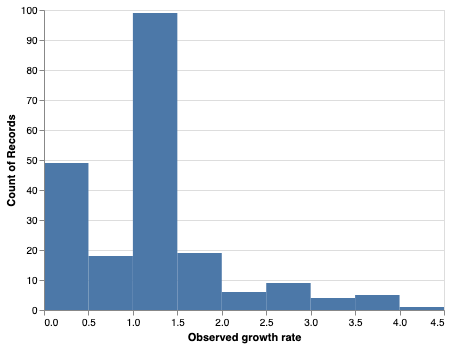

In [54]:
alt.Chart(complete_clade_frequencies).mark_rect().encode(
    x=alt.X("observed_growth_rate:Q", bin=True, title="Observed growth rate"),
    y="count()"
)

In [55]:
complete_clade_frequencies["year"] = complete_clade_frequencies["timepoint"].dt.year

In [56]:
complete_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,projected_frequency,observed_growth_rate,estimated_growth_rate,year
2,2040-04-01,be85840,0.44,0.45,0.28,1.022727,0.636364,2040
4,2040-10-01,348a0f0,0.21,0.47,0.23,2.238095,1.095238,2040
5,2040-10-01,5198bfc,0.62,0.65,0.49,1.048387,0.790323,2040
6,2040-10-01,777355b,0.16,0.30,0.38,1.875000,2.375000,2040
7,2040-10-01,84b5f88,0.16,0.15,0.11,0.937500,0.687500,2040


In [57]:
complete_clade_frequencies.shape

(210, 8)

In [58]:
r, p = pearsonr(
    complete_clade_frequencies["observed_growth_rate"],
    complete_clade_frequencies["estimated_growth_rate"]
)

In [59]:
r

0.2390983742909612

In [60]:
p

0.0004740365551019041

In [61]:
mcc, confusion_matrix = get_matthews_correlation_coefficient_for_data_frame(complete_clade_frequencies, True)

In [62]:
mcc

0.367640845101626

In [63]:
confusion_matrix

{'tp': 99, 'tn': 46, 'fp': 21, 'fn': 42}

In [64]:
sum(confusion_matrix.values())

208

In [65]:
growth_accuracy = confusion_matrix["tp"] / float(confusion_matrix["tp"] + confusion_matrix["fp"])
growth_accuracy

0.825

In [66]:
decline_accuracy = confusion_matrix["tn"] / float(confusion_matrix["tn"] + confusion_matrix["fn"])
decline_accuracy

0.5227272727272727

In [67]:
min_growth_rate = 0
max_growth_rate = complete_clade_frequencies.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max() + 0.2

In [68]:
pseudofrequency = 0.001

In [69]:
complete_clade_frequencies["log_observed_growth_rate"] = (
    np.log10((complete_clade_frequencies["frequency_final"] + pseudofrequency) / (complete_clade_frequencies["frequency"] + pseudofrequency))
)

complete_clade_frequencies["log_estimated_growth_rate"] = (
    np.log10((complete_clade_frequencies["projected_frequency"] + pseudofrequency) / (complete_clade_frequencies["frequency"] + pseudofrequency))
)

In [70]:
upper_limit = np.ceil(complete_clade_frequencies.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max())

log_lower_limit = complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].min().min() - 0.1
log_upper_limit = np.ceil(complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].max().max()) + 0.1

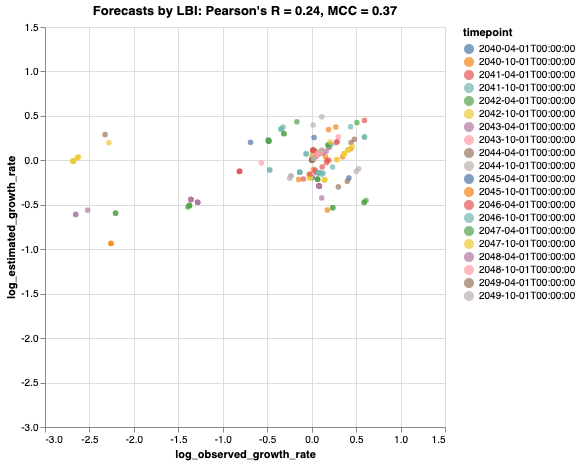

In [71]:
tooltip_attributes = ["observed_growth_rate:Q", "estimated_growth_rate:Q", "timepoint:N", "frequency:Q", "frequency_final:Q",
                      "projected_frequency:Q", "clade_membership:N"]

chart = alt.Chart(complete_clade_frequencies).mark_circle().encode(
    alt.X("log_observed_growth_rate:Q", scale=alt.Scale(domain=(log_lower_limit, log_upper_limit))),
    alt.Y("log_estimated_growth_rate:Q", scale=alt.Scale(domain=(log_lower_limit, log_upper_limit))),
    alt.Color("timepoint:N"),
    alt.Tooltip(tooltip_attributes)
).properties(
    width=400,
    height=400,
    title="Forecasts by LBI: Pearson's R = %.2f, MCC = %.2f" % (r, mcc)
).interactive()

#chart.save("forecast_log_growth_correlation_natural_lbi.svg")
chart

In [72]:
log_lower_limit

-2.782145076373832

In [73]:
complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].min().min()

-2.682145076373832

In [74]:
r, p = pearsonr(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"]
)

In [75]:
r

0.3651479394819816

In [76]:
p

5.058363068670378e-08

In [77]:
pearsonr(
    complete_clade_frequencies["observed_growth_rate"],
    complete_clade_frequencies["estimated_growth_rate"]
)

(0.2390983742909612, 0.0004740365551019041)

In [78]:
complete_clade_frequencies["observed_growth"] = (complete_clade_frequencies["observed_growth_rate"] > 1)

In [79]:
complete_clade_frequencies["estimated_growth"] = (complete_clade_frequencies["estimated_growth_rate"] > 1)

In [80]:
complete_clade_frequencies.aggregate({"observed_growth": "sum", "estimated_growth": "sum"})

observed_growth     143
estimated_growth    120
dtype: int64

In [81]:
complete_clade_frequencies["accurate_growth"] = (
    (complete_clade_frequencies["observed_growth"]) == (complete_clade_frequencies["estimated_growth"])
)

In [82]:
confusion_matrix

{'tp': 99, 'tn': 46, 'fp': 21, 'fn': 42}

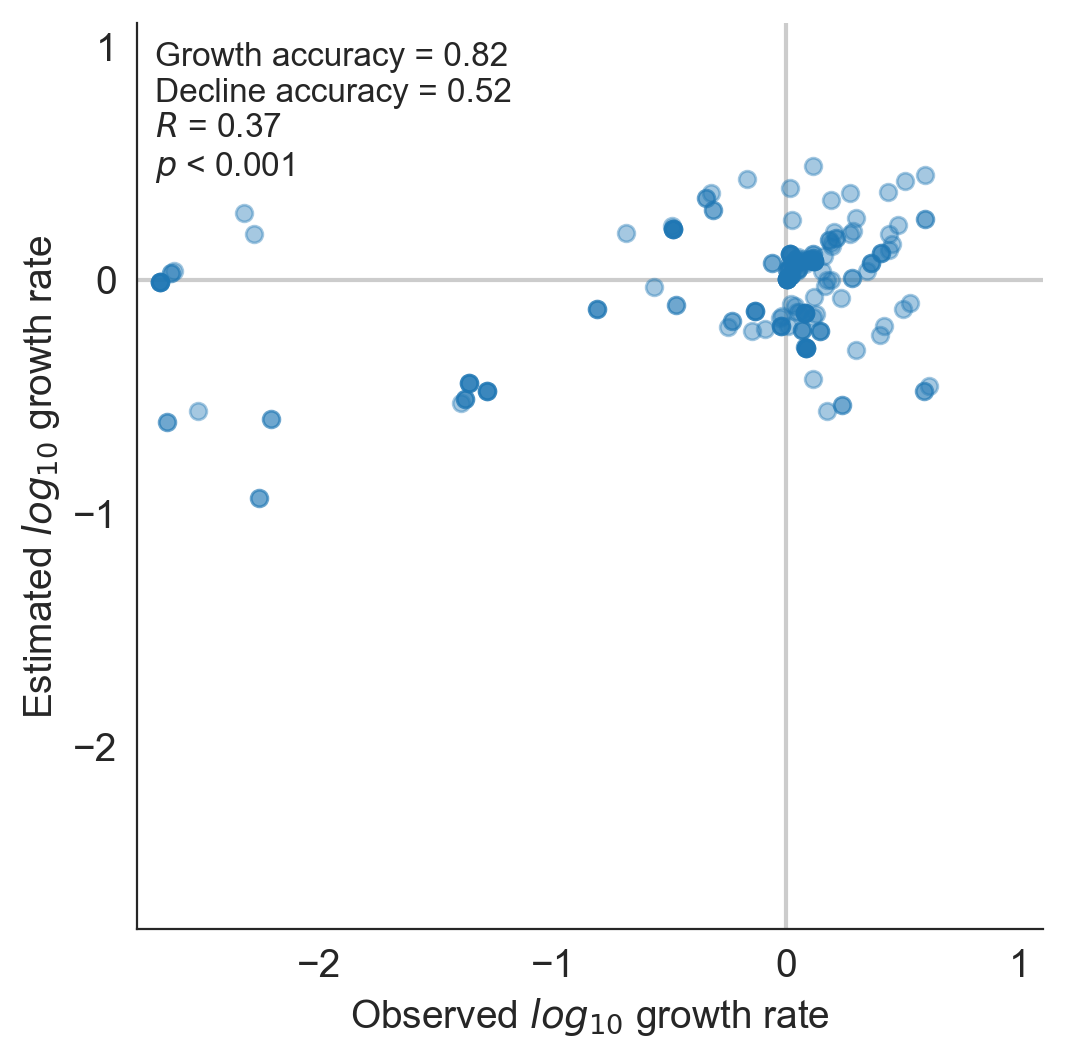

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

ax.axhline(color="#cccccc", zorder=-5)
ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

ax.text(
    0.02,
    0.9,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\n$R$ = %.2f\n%s" % (growth_accuracy, decline_accuracy, r, p_value),
    fontsize=12,
    horizontalalignment="left",
    verticalalignment="center",
    transform=ax.transAxes
)

ax.set_xlabel("Observed $log_{10}$ growth rate")
ax.set_ylabel("Estimated $log_{10}$ growth rate")

ticks = np.arange(-6, 4, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xlim(log_lower_limit, log_upper_limit)
ax.set_ylim(log_lower_limit, log_upper_limit)
ax.set_aspect("equal")

#plt.savefig("../manuscript/figures/validation-of-best-model-for-natural-populations.pdf")

In [84]:
false_positives = (complete_clade_frequencies["log_observed_growth_rate"] < 0) & (complete_clade_frequencies["log_estimated_growth_rate"] > 0)

In [85]:
confusion_matrix

{'tp': 99, 'tn': 46, 'fp': 21, 'fn': 42}

In [86]:
complete_clade_frequencies[false_positives].sort_values("frequency")

,timepoint,clade_membership,frequency,frequency_final,projected_frequency,observed_growth_rate,estimated_growth_rate,year,log_observed_growth_rate,log_estimated_growth_rate,observed_growth,estimated_growth,accurate_growth
143,2045-04-01,781dea1,0.15,0.03,0.24,0.200000,1.600000,2045,-0.687615,0.203040,False,True,False
216,2046-10-01,6c9b489,0.19,0.09,0.45,0.473684,2.368421,2046,-0.321992,0.373143,False,True,False
302,2047-10-01,f01e466,0.19,0.00,0.30,0.000000,1.578947,2047,-2.281033,0.197533,False,True,False
229,2046-10-01,ef4e13c,0.20,0.09,0.45,0.450000,2.250000,2046,-0.344155,0.350980,False,True,False
230,2046-10-01,f1a9cc3,0.20,0.09,0.45,0.450000,2.250000,2046,-0.344155,0.350980,False,True,False
102,2044-04-01,227dcf9,0.21,0.00,0.41,0.000000,1.952381,2044,-2.324282,0.289559,False,True,False
270,2047-04-01,ff00056,0.25,0.17,0.68,0.680000,2.720000,2047,-0.166678,0.433473,False,True,False
202,2046-10-01,089dcd8,0.28,0.09,0.48,0.321429,1.714286,2046,-0.489665,0.233439,False,True,False
261,2047-04-01,bd373a9,0.35,0.17,0.70,0.485714,2.000000,2047,-0.312311,0.300411,False,True,False
253,2047-04-01,7a20891,0.35,0.17,0.70,0.485714,2.000000,2047,-0.312311,0.300411,False,True,False


## Estimated and observed closest strains per timepoint

Create a figure similar to Figure 2D in Neher et al. 2014 showing the minimum estimated distance to the future and minimum observed distance to the future per timepoint.

In [87]:
sorted_df = full_forecasts.dropna().sort_values(
    ["timepoint"]
).copy()

In [88]:
sorted_df["timepoint_rank"] = sorted_df.groupby("timepoint")["weighted_distance_to_future"].rank(pct=True)

In [89]:
best_fitness_rank_by_timepoint_df = sorted_df.sort_values(
    ["timepoint", "fitness"],
    ascending=False
).groupby("timepoint")["timepoint_rank"].first().reset_index()

In [90]:
best_fitness_rank_by_timepoint_df.head()

,timepoint,timepoint_rank
0,2040-04-01,0.025397
1,2040-10-01,0.228571
2,2041-04-01,0.007143
3,2041-10-01,0.025397
4,2042-04-01,0.011905


Text(0,0.5,'Number of timepoints')

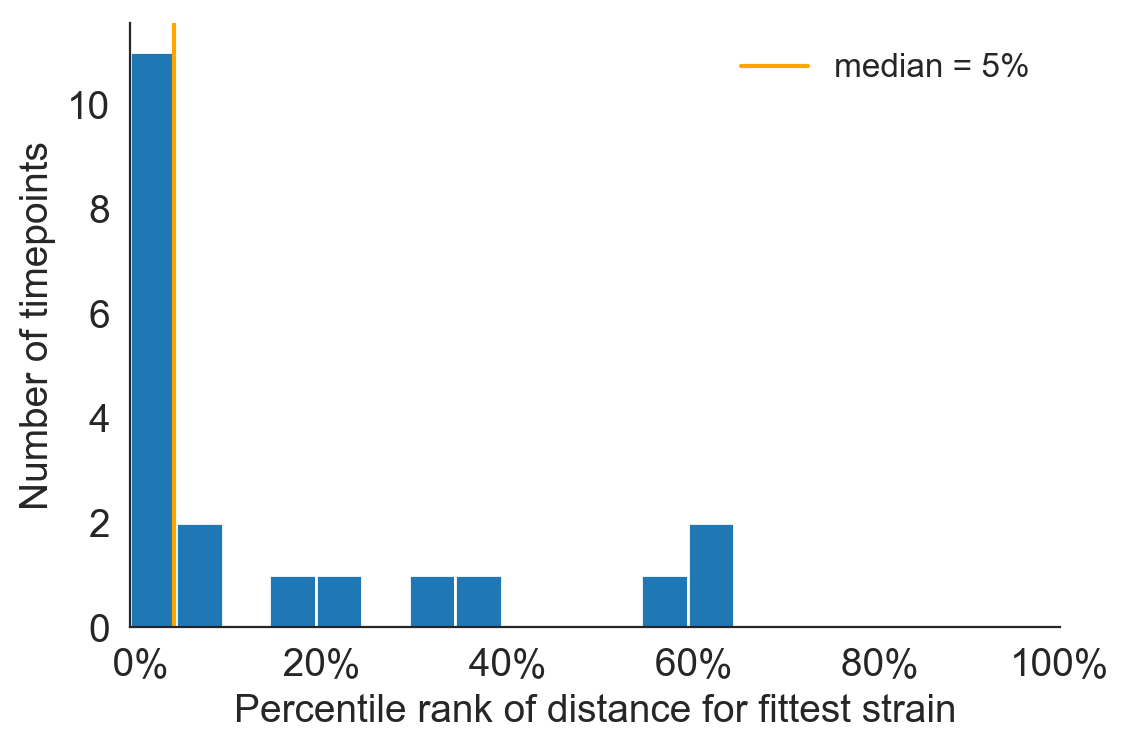

In [91]:
median_best_rank = best_fitness_rank_by_timepoint_df["timepoint_rank"].median()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(best_fitness_rank_by_timepoint_df["timepoint_rank"], bins=np.arange(0, 1.01, 0.05), label=None)
ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i%%" % round(median_best_rank * 100, 0)
)
ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
ax.set_xlim(0, 1)

ax.legend(
    frameon=False
)
ax.set_xlabel("Percentile rank of distance for fittest strain")
ax.set_ylabel("Number of timepoints")

## Merge validation figures into subpanels of one figure

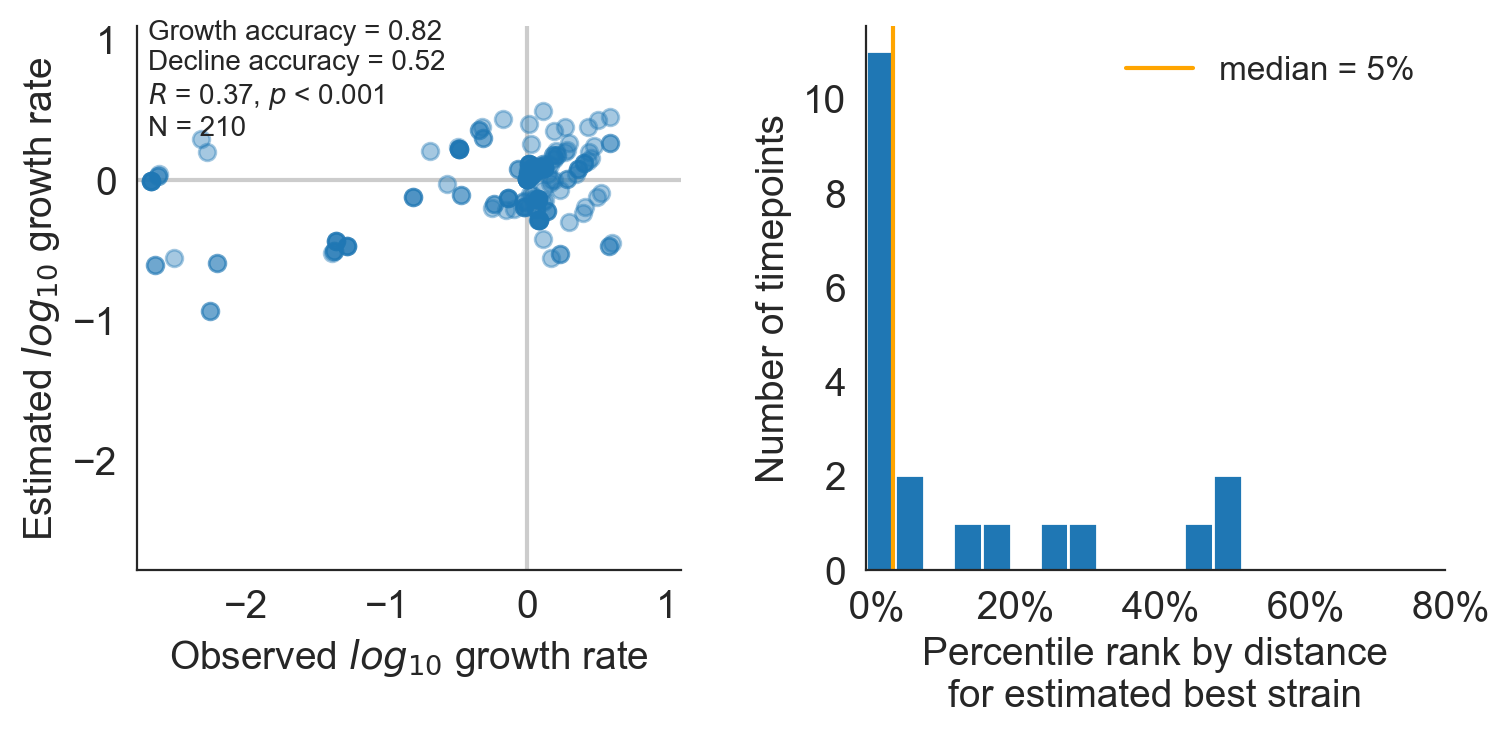

In [92]:
fig = plt.figure(figsize=(8, 4), facecolor='w')
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)

#
# Clade growth rate correlations
#

clade_ax = fig.add_subplot(gs[0])
clade_ax.plot(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

clade_ax.axhline(color="#cccccc", zorder=-5)
clade_ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

clade_ax.text(
    0.02,
    0.9,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\n$R$ = %.2f, %s\nN = %s" % (growth_accuracy, decline_accuracy, r, p_value, complete_clade_frequencies.shape[0]),
    fontsize=10,
    horizontalalignment="left",
    verticalalignment="center",
    transform=clade_ax.transAxes
)

clade_ax.set_xlabel("Observed $log_{10}$ growth rate")
clade_ax.set_ylabel("Estimated $log_{10}$ growth rate")

ticks = np.arange(-6, 4, 1)
clade_ax.set_xticks(ticks)
clade_ax.set_yticks(ticks)

clade_ax.set_xlim(log_lower_limit, log_upper_limit)
clade_ax.set_ylim(log_lower_limit, log_upper_limit)
clade_ax.set_aspect("equal")

#
# Estimated closest strain to the future ranking
#

rank_ax = fig.add_subplot(gs[1])

median_best_rank = best_fitness_rank_by_timepoint_df["timepoint_rank"].median()

rank_ax.hist(best_fitness_rank_by_timepoint_df["timepoint_rank"], bins=np.arange(0, 1.01, 0.05), label=None)
rank_ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i%%" % round(median_best_rank * 100, 0)
)
rank_ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
rank_ax.set_xlim(0, 1)

rank_ax.legend(
    frameon=False
)
rank_ax.set_xlabel("Percentile rank by distance\nfor estimated best strain")
rank_ax.set_ylabel("Number of timepoints")

gs.tight_layout(fig)

plt.savefig("../manuscript/figures/test-of-best-model-for-simulated-populations.png")

In [93]:
(best_fitness_rank_by_timepoint_df["timepoint_rank"] <= 0.2).sum()

14

In [94]:
best_fitness_rank_by_timepoint_df.shape

(20, 2)

In [95]:
(best_fitness_rank_by_timepoint_df["timepoint_rank"] <= 0.2).sum() / float(best_fitness_rank_by_timepoint_df.shape[0])

0.7